# Trigger Trading Strategy

### description



In [1]:
# packages
import datetime as dt
import pandas as pd
import yfinance as yf

from quantified_strategies import strategy_utils
import utils

In [2]:
def get_data(ticker: str, start: dt.date = None, end: dt.date = None) -> pd.DataFrame:

    try:
        px = strategy_utils.get_intraday_data(ticker=ticker, start=start, end=end)
        px.index = px.index.tz_localize("UTC")
        px["Adj Close"] = px["Close"]
        return px 
    except:    
        INTERVALS = ["1m", "2m", "5m", "15m", "30m"]
        intervals = utils.fetch_intervals()
    
        pxs = []
        for interval, from_date, to_date  in intervals:
            
            if interval not in INTERVALS:
                continue
            
            px = yf.download(ticker, start=from_date, end=to_date, interval=interval, progress=False)
            pxs.append(px)
    
        px = pd.concat(pxs, axis=0)
        px = px.sort_index()
    
        px = px.loc[(px.index.date >= start) & (px.index.date <= end)]
        
        return px



In [48]:
# settings

TRIGGER_ASSETS = ["GBPUSD=X", "CL=F"]
TRIGGER_ASSETS = ["GBPEUR.FOREX", "CL=F"]
OLD_TRADE_ASSETS = ["^FTSE", "EUEA.AS"]
OLD_TRADE_ASSETS = ["ISF.LSE", "EUEA.AS"]
TRADE_ASSETS_DICT = {asset: asset.replace("^", "").replace(".", "") for asset in OLD_TRADE_ASSETS}
TRADE_ASSETS = [TRADE_ASSETS_DICT.get(ticker, ticker) for ticker in OLD_TRADE_ASSETS]
TRADE_SPREAD = " - ".join(TRADE_ASSETS)

TRADE_LOWER_BOUND = dt.time(9, 0)
TRADE_UPPER_BOUND = dt.time(16, 0)

WINDOW = 30

START = dt.date(2024, 1, 25)
END = dt.date.today()

In [4]:
get_data(ticker="EUEA.AS", start=START, end=END)

remove api from here


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-01-25 09:04:00+01:00,46.404999,46.404999,46.395000,46.395000,46.395000,0
2024-01-25 09:06:00+01:00,46.389999,46.389999,46.389999,46.389999,46.389999,2
2024-01-25 09:10:00+01:00,46.435001,46.435001,46.400002,46.400002,46.400002,379
2024-01-25 09:12:00+01:00,46.410000,46.410000,46.410000,46.410000,46.410000,6
2024-01-25 09:18:00+01:00,46.360001,46.360001,46.349998,46.349998,46.349998,21
...,...,...,...,...,...,...
2024-03-04 17:07:00+01:00,49.834999,49.834999,49.834999,49.834999,49.834999,2
2024-03-04 17:11:00+01:00,49.834999,49.834999,49.834999,49.834999,49.834999,18
2024-03-04 17:16:00+01:00,49.840000,49.840000,49.840000,49.840000,49.840000,26


## Get Data

In [5]:
trigger_data_dict = {ticker: get_data(ticker=ticker, start=START, end=END) for ticker in TRIGGER_ASSETS}
trade_data_dict = {ticker: get_data(ticker=ticker, start=START, end=END) for ticker in OLD_TRADE_ASSETS}

remove api from here
remove api from here
remove api from here
remove api from here


In [6]:
trigger_data_df = pd.concat([trigger_data_dict[ticker]["Adj Close"].to_frame(name=ticker) for ticker in TRIGGER_ASSETS], axis=1)
trade_data_df = pd.concat([trade_data_dict[ticker]["Adj Close"].to_frame(name=TRADE_ASSETS_DICT.get(ticker, ticker)) for ticker in OLD_TRADE_ASSETS], axis=1)

trigger_data_df = trigger_data_df.resample("1min").last()
trade_data_df = trade_data_df.resample("1min").last()

trigger_data_df = trigger_data_df.ffill()
trade_data_df = trade_data_df.ffill()

trigger_data_df["date"] = trigger_data_df.index.date
trade_data_df["date"] = trade_data_df.index.date


In [7]:
trigger_return_df = trigger_data_df.ffill().groupby("date").pct_change(fill_method=None)
trigger_return_df["date"] = trigger_return_df.index.date
trigger_return_df = trigger_return_df.groupby("date").rolling(window=WINDOW).apply(lambda x: (1 + x).prod() - 1).reset_index(level=0, drop=True)
trigger_return_df

,GBPEUR.FOREX,CL=F
2024-01-25 00:00:00+00:00,NaN,NaN
2024-01-25 00:01:00+00:00,NaN,NaN
2024-01-25 00:02:00+00:00,NaN,NaN
2024-01-25 00:03:00+00:00,NaN,NaN
2024-01-25 00:04:00+00:00,NaN,NaN
...,...,...
2024-03-05 07:48:00+00:00,0.000154,0.0
2024-03-05 07:49:00+00:00,0.000154,0.0
2024-03-05 07:50:00+00:00,-0.000094,0.0
2024-03-05 07:51:00+00:00,0.000077,0.0


In [8]:
trade_return_df = trade_data_df.ffill().groupby("date").pct_change(fill_method=None)
trade_return_df["date"] = trade_return_df.index.date
trade_return_df = trade_return_df.groupby("date").rolling(window=30).apply(lambda x: (1 + x).prod() - 1).reset_index(level=0, drop=True)
trade_return_df

,ISFLSE,EUEAAS
2024-01-25 08:00:00+00:00,NaN,NaN
2024-01-25 08:01:00+00:00,NaN,NaN
2024-01-25 08:02:00+00:00,NaN,NaN
2024-01-25 08:03:00+00:00,NaN,NaN
2024-01-25 08:04:00+00:00,NaN,NaN
...,...,...
2024-03-05 15:29:00+00:00,-0.000270,0.0
2024-03-05 15:30:00+00:00,-0.000404,0.0
2024-03-05 15:31:00+00:00,-0.000428,0.0
2024-03-05 15:32:00+00:00,-0.000990,0.0


In [9]:
# Create triggers on 'x' bp move
TRIGGER_MOVE_BPS_DICT = {asset: 2 * trigger_data_df[asset].resample("30min").last().pct_change().std() * 10_000 for asset in TRIGGER_ASSETS}
TRIGGER_MOVE_BPS_DICT

{'GBPEUR.FOREX': 6.15346836398818, 'CL=F': 44.92375746690127}

In [10]:
{asset: 2 * trade_data_df[asset].resample("30min").last().pct_change().std() * 10_000 for asset in TRADE_ASSETS}

{'ISFLSE': 14.621890421922334, 'EUEAAS': 14.314434481129434}

In [66]:
import typing as t


def get_triggers(df: pd.DataFrame, sign: str = ">"):

    assert sign in [">", "<"]
    
    triggers_dict = dict()
    for i, ticker in enumerate(TRIGGER_ASSETS):

        if sign == ">":
            trigger_df = df[ticker] > (TRIGGER_MOVE_BPS_DICT[ticker] / 10_000)
        elif sign == "<":
            trigger_df = df[ticker] < -(TRIGGER_MOVE_BPS_DICT[ticker] / 10_000)
        
        triggers = trigger_df.loc[trigger_df].index.tolist()
        

        i = 0
        n = 10
        while i < n:
            trigger0 = triggers[i]
            try:
                if trigger0.time() < TRADE_LOWER_BOUND or trigger0.time() > TRADE_UPPER_BOUND:
                    i += 1
                    continue
                break
            except:
                return triggers_dict()
            
        triggers_dict[ticker] = [trigger0]

        for trigger in triggers:

            if trigger.time() < TRADE_LOWER_BOUND or trigger.time() > TRADE_UPPER_BOUND:
                # print(trigger)
                continue
                
            if (trigger - trigger0).total_seconds() < WINDOW * 60:
                continue
                
            trigger0 = trigger
            triggers_dict[ticker].append(trigger)

    return triggers_dict


def combine_triggers(triggers_dict: t.Dict[str, pd.Timestamp]) -> t.List[pd.Timestamp]:

    ticker1 = TRIGGER_ASSETS[0]
    ticker2 = TRIGGER_ASSETS[1]
    
    combo_triggers = []
    for ts1 in triggers_dict[ticker1]:
        for ts2 in triggers_dict[ticker2]:
            if abs((ts1 - ts2).total_seconds()) < 10 * 60:
                combo_triggers.append(max(ts1, ts2))

    return combo_triggers



In [67]:
triggers_pos_dict = get_triggers(df=trigger_return_df, sign=">")
triggers_neg_dict = get_triggers(df=trigger_return_df, sign="<")
triggers_dict = {">": triggers_pos_dict, "<": triggers_neg_dict}
triggers_dict

{'>': {'GBPEUR.FOREX': [Timestamp('2024-01-25 09:27:00+0000', tz='UTC'),
   Timestamp('2024-01-25 10:08:00+0000', tz='UTC'),
   Timestamp('2024-01-25 13:05:00+0000', tz='UTC'),
   Timestamp('2024-01-25 13:53:00+0000', tz='UTC'),
   Timestamp('2024-01-25 14:23:00+0000', tz='UTC'),
   Timestamp('2024-01-25 15:02:00+0000', tz='UTC'),
   Timestamp('2024-01-26 09:29:00+0000', tz='UTC'),
   Timestamp('2024-01-26 13:31:00+0000', tz='UTC'),
   Timestamp('2024-01-26 14:04:00+0000', tz='UTC'),
   Timestamp('2024-01-29 09:15:00+0000', tz='UTC'),
   Timestamp('2024-01-29 10:30:00+0000', tz='UTC'),
   Timestamp('2024-01-29 14:14:00+0000', tz='UTC'),
   Timestamp('2024-01-29 15:42:00+0000', tz='UTC'),
   Timestamp('2024-01-30 12:12:00+0000', tz='UTC'),
   Timestamp('2024-01-30 13:35:00+0000', tz='UTC'),
   Timestamp('2024-01-30 14:05:00+0000', tz='UTC'),
   Timestamp('2024-01-30 15:49:00+0000', tz='UTC'),
   Timestamp('2024-01-31 14:47:00+0000', tz='UTC'),
   Timestamp('2024-01-31 15:24:00+0000', tz

In [69]:
combo_pos_trigger = {"combo": combine_triggers(triggers_dict=triggers_pos_dict)}
combo_neg_trigger = {"combo": combine_triggers(triggers_dict=triggers_neg_dict)}

In [70]:
# Create markout on trigger

In [71]:
import numpy as np
from tqdm import tqdm
import typing as t


def get_around(df: pd.DataFrame, index: int, column: str, n: int) -> (pd.Series, pd.Series):
    
    """Return n rows before and n rows after the specified positional index"""
    indices = df.index.tolist()
    
    before_indices = [indices.index(index) - i for i in range(n, -1, -1)]
    before_df = df[column].iloc[before_indices]

    after_indices = [indices.index(index) + i for i in range(n+1)]
    after_df = df[column].iloc[after_indices]

    return before_df, after_df

def get_before_build_up(before_df: pd.DataFrame):
    return ((before_df.pct_change() + 1).cumprod() - (before_df.pct_change() + 1).prod()).dropna()

def get_after_build_up(after_df: pd.DataFrame):
    return (after_df.pct_change().fillna(0.0) + 1).cumprod() - 1

def get_before_after_dicts(df: pd.DataFrame, triggers_dict: t.Dict[str, pd.Timestamp], N: int = np.inf) -> t.Dict[str, t.Tuple[pd.Series, pd.Series]]:

    before_after_dicts = dict()
    for column in df.columns:

        if column in triggers_dict:
            indices = triggers_dict[column]
        else:
            indices = sum([indices_ for _, indices_ in triggers_dict.items()], [])

        df = df.reindex(index=df.index.union(indices))
        df = df.sort_index()
        df = df.ffill()
        
        before_after_dicts[column] = []
        
        for idx in tqdm(indices):
            try:
                before_df, after_df = get_around(df=df, index=idx, column=column, n=WINDOW)
            except IndexError:
                continue
            
            before_df = get_before_build_up(before_df=before_df)
            after_df = get_after_build_up(after_df=after_df)

            before_after_dicts[column].append((before_df, after_df))

            if len(before_after_dicts[column]) > N:
                break
    
    return before_after_dicts



In [72]:
pos_trigger_before_after_dicts = get_before_after_dicts(df=trigger_data_df[TRIGGER_ASSETS], triggers_dict=combo_pos_trigger)
neg_trigger_before_after_dicts = get_before_after_dicts(df=trigger_data_df[TRIGGER_ASSETS], triggers_dict=combo_neg_trigger)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.29it/s]


In [73]:
trigger_before_after_dicts = dict()
for asset in TRIGGER_ASSETS:
    trigger_before_after_dicts[asset] = pos_trigger_before_after_dicts[asset]
    trigger_before_after_dicts[asset] += [(-b, -a) for b, a in neg_trigger_before_after_dicts[asset]]
    

In [74]:
pos_trade_before_after_dicts = get_before_after_dicts(df=trade_data_df[TRADE_ASSETS], triggers_dict=combo_pos_trigger)
neg_trade_before_after_dicts = get_before_after_dicts(df=trade_data_df[TRADE_ASSETS], triggers_dict=combo_neg_trigger)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.08it/s]


In [75]:
trade_before_after_dicts = dict()
for asset in TRADE_ASSETS:
    trade_before_after_dicts[asset] = pos_trade_before_after_dicts[asset]
    trade_before_after_dicts[asset] += [(-b, -a) for b, a in neg_trade_before_after_dicts[asset]]
    

In [76]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator

asset = 'GBPEUR.FOREX' -> 26
Potential Fault: asset = 'GBPEUR.FOREX' and j=9
asset = 'CL=F' -> 26
Potential Fault: asset = 'CL=F' and j=5


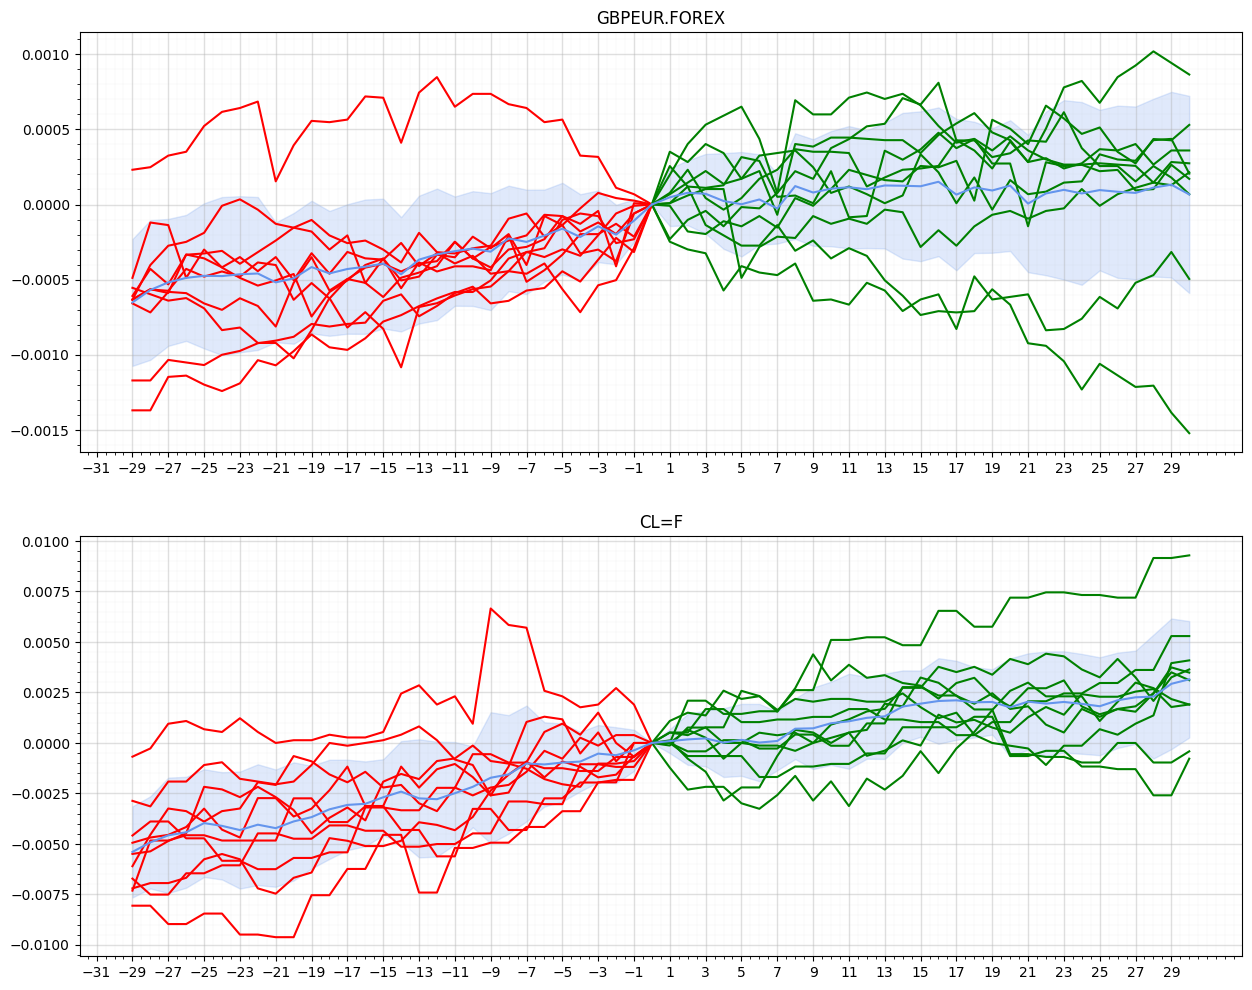

In [80]:
N = 10

fig, ax = plt.subplots(nrows=len(TRIGGER_ASSETS), figsize=(15, 12))
# fig, ax = plt.subplots(nrows=len(TRADE_ASSETS), figsize=(15, 12))

for i, asset in enumerate(TRIGGER_ASSETS):
# for i, asset in enumerate(TRADE_ASSETS):

    ax[i].set_title(asset)
    
    before_dfs = []
    after_dfs = []

    print(f"{asset = !r} -> {len(trigger_before_after_dicts[asset])}")
    
    for j, (b_df, a_df) in enumerate(trigger_before_after_dicts[asset][:N]):
    # for b_df, a_df in trade_before_after_dicts[asset][:N]:
        
        b_df_ = b_df.reset_index(drop=True).copy()
        b_df_.index = [-idx for idx in b_df_.index[::-1]]

        if b_df_.iloc[0] > 0 or (b_df_ > 0).mean() > 0.5:
            print(f"Potential Fault: {asset = } and {j=}")
            
        a_df_ = a_df.reset_index(drop=True).copy()

        before_dfs.append(b_df_)
        after_dfs.append(a_df_)
        
        ax[i].plot(b_df_, color="r")
        ax[i].plot(a_df_, color="g")        
    
    before_dfs = pd.concat(before_dfs, axis=1)
    after_dfs = pd.concat(after_dfs, axis=1)

    ax[i].plot(before_dfs.mean(axis=1), color="cornflowerblue")    
    ax[i].fill_between(before_dfs.index, before_dfs.mean(axis=1) - before_dfs.std(axis=1), before_dfs.mean(axis=1) + before_dfs.std(axis=1), color="cornflowerblue", alpha=0.2)
    ax[i].plot(after_dfs.mean(axis=1), color="cornflowerblue")
    ax[i].fill_between(after_dfs.index, after_dfs.mean(axis=1) - after_dfs.std(axis=1), after_dfs.mean(axis=1) + after_dfs.std(axis=1), color="cornflowerblue", alpha=0.2)


for ax_ in ax:
    ax_.grid(which = "major", linewidth = 1, alpha = 0.4)
    ax_.grid(which = "minor", linewidth = 0.2, alpha = 0.2)
    ax_.minorticks_on()

    ax_.xaxis.set_major_locator(FixedLocator([*range(-(WINDOW+1), WINDOW+1, 2)]))

plt.show()

In [81]:
trigger_before_after_dicts["GBPEUR.FOREX"][9]

(2024-02-29 15:26:00+00:00    0.000231
 2024-02-29 15:27:00+00:00    0.000248
 2024-02-29 15:28:00+00:00    0.000325
 2024-02-29 15:29:00+00:00    0.000351
 2024-02-29 15:30:00+00:00    0.000522
 2024-02-29 15:31:00+00:00    0.000616
 2024-02-29 15:32:00+00:00    0.000642
 2024-02-29 15:33:00+00:00    0.000685
 2024-02-29 15:34:00+00:00    0.000154
 2024-02-29 15:35:00+00:00    0.000394
 2024-02-29 15:36:00+00:00    0.000556
 2024-02-29 15:37:00+00:00    0.000548
 2024-02-29 15:38:00+00:00    0.000565
 2024-02-29 15:39:00+00:00    0.000719
 2024-02-29 15:40:00+00:00    0.000710
 2024-02-29 15:41:00+00:00    0.000411
 2024-02-29 15:42:00+00:00    0.000745
 2024-02-29 15:43:00+00:00    0.000847
 2024-02-29 15:44:00+00:00    0.000650
 2024-02-29 15:45:00+00:00    0.000736
 2024-02-29 15:46:00+00:00    0.000736
 2024-02-29 15:47:00+00:00    0.000667
 2024-02-29 15:48:00+00:00    0.000642
 2024-02-29 15:49:00+00:00    0.000548
 2024-02-29 15:50:00+00:00    0.000565
 2024-02-29 15:51:00+00:0

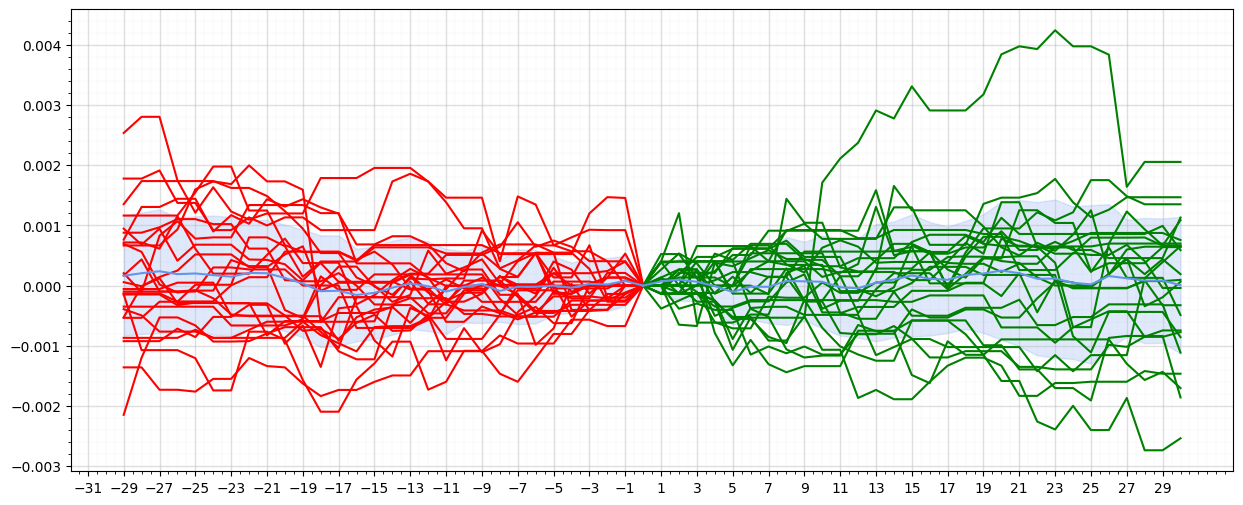

In [82]:
N = 100

TRIGGER_ASSETS_USED = ["CL=F"]

# fig, ax = plt.subplots(nrows=len(TRIGGER_ASSETS), figsize=(15, 12))
fig, ax = plt.subplots(nrows=len(TRIGGER_ASSETS_USED), figsize=(15, 6 * len(TRIGGER_ASSETS_USED)))

ax = ax if isinstance(ax, list) else [ax]

for i, trigger_asset in enumerate(TRIGGER_ASSETS_USED):
    
    tuples = trigger_before_after_dicts[trigger_asset]
    before_df_list = []
    after_df_list = []

    for j, (b_df, a_df) in enumerate(tuples):

        try:
            before_dfs = pd.concat([trade_before_after_dicts[asset][j][0] for asset in TRADE_ASSETS], axis=1)
            after_dfs = pd.concat([trade_before_after_dicts[asset][j][1] for asset in TRADE_ASSETS], axis=1)
        except IndexError:
            continue
        
        before_dfs = before_dfs.reset_index(drop=True).copy()
        before_dfs.index = [-idx for idx in before_dfs.index[::-1]]
        after_dfs = after_dfs.reset_index(drop=True).copy()

        before_df = -before_dfs.eval(TRADE_SPREAD)
        after_df = -after_dfs.eval(TRADE_SPREAD)

        before_df_list.append(before_df)
        after_df_list.append(after_df)

        ax[i].plot(before_df, color="r")
        ax[i].plot(after_df, color="g")

        if j >= N:
            break
    
    before_dfs = pd.concat(before_df_list, axis=1)
    after_dfs = pd.concat(after_df_list, axis=1)

    ax[i].plot(before_dfs.mean(axis=1), color="cornflowerblue")    
    ax[i].fill_between(before_dfs.index, before_dfs.mean(axis=1) - before_dfs.std(axis=1), before_dfs.mean(axis=1) + before_dfs.std(axis=1), color="cornflowerblue", alpha=0.2)
    ax[i].plot(after_dfs.mean(axis=1), color="cornflowerblue")
    ax[i].fill_between(after_dfs.index, after_dfs.mean(axis=1) - after_dfs.std(axis=1), after_dfs.mean(axis=1) + after_dfs.std(axis=1), color="cornflowerblue", alpha=0.2)


for ax_ in ax:
    ax_.grid(which = "major", linewidth = 1, alpha = 0.4)
    ax_.grid(which = "minor", linewidth = 0.2, alpha = 0.2)
    ax_.minorticks_on()

    ax_.xaxis.set_major_locator(FixedLocator([*range(-(WINDOW+1), WINDOW+1, 2)]))

plt.show()

<Axes: >

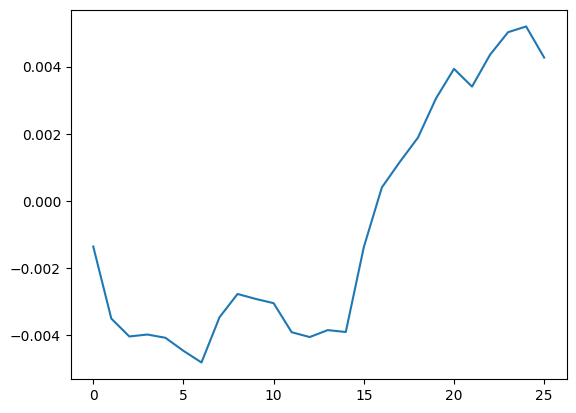

In [83]:
((before_dfs.loc[-29] + 1).cumprod() - 1).plot()

<Axes: >

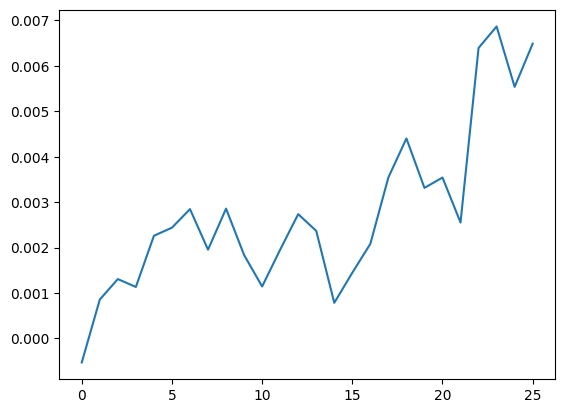

In [158]:
n = 20
# ((after_dfs.loc[n] + 1).cumprod() - 1).plot()
after_dfs.loc[n].cumsum().plot()

In [140]:
(after_dfs > 0).sum(axis=1) / (after_dfs != 0).sum(axis=1)

0          NaN
1     0.666667
2     0.619048
3     0.608696
4     0.520000
5     0.458333
6     0.480000
7     0.500000
8     0.653846
9     0.576923
10    0.576923
11    0.500000
12    0.423077
13    0.500000
14    0.538462
15    0.615385
16    0.615385
17    0.500000
18    0.653846
19    0.653846
20    0.615385
21    0.653846
22    0.615385
23    0.692308
24    0.538462
25    0.461538
26    0.576923
27    0.576923
28    0.653846
29    0.576923
30    0.576923
dtype: float64

In [163]:
after_dfs.loc[:, after_dfs.columns != 22].mean(axis=1) * 10_000

0     0.000000
1     0.579859
2     1.039528
3     0.776217
4     0.023317
5    -0.665900
6     0.032526
7     0.010744
8     1.016609
9     0.958965
10   -0.015829
11   -1.120959
12   -1.400835
13   -0.650435
14   -0.047508
15    0.434561
16    0.024088
17   -0.153607
18    0.685210
19    0.821735
20    1.057850
21    0.561966
22   -0.384758
23   -0.473230
24   -1.094998
25   -1.376725
26    0.132416
27    0.611910
28    0.054238
29    0.053467
30   -0.737671
dtype: float64

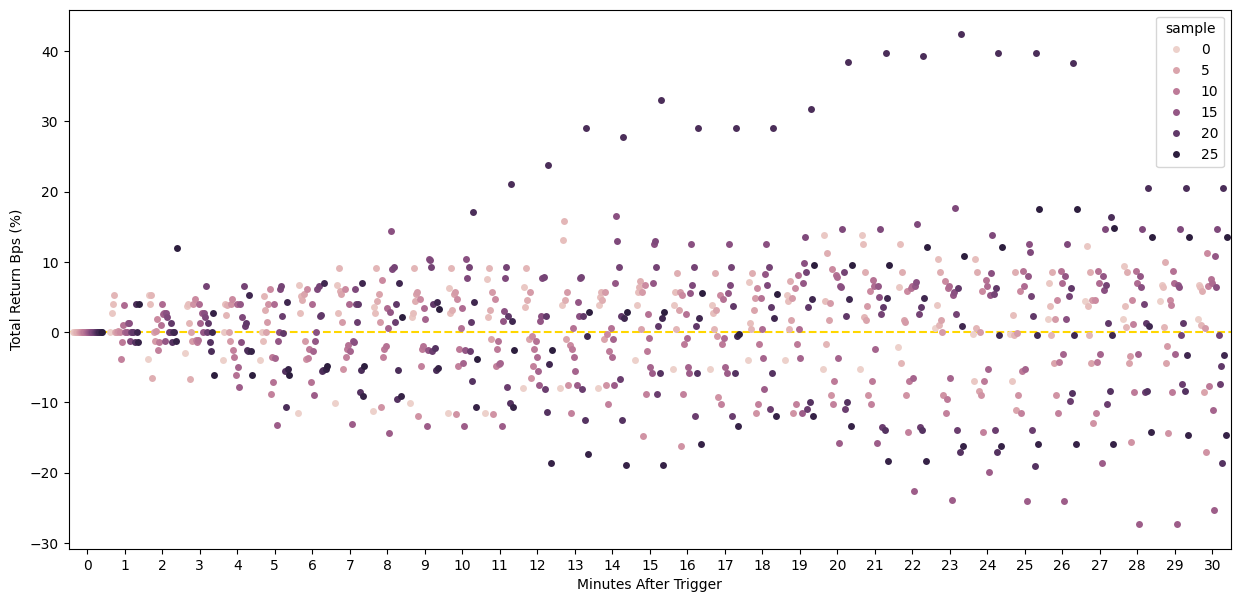

In [133]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 7))

ret = (after_dfs* 10_000)

data = (
    ret
    .reset_index()
    .rename(columns={"index": "minutes"})
    .melt(id_vars="minutes", var_name="sample", value_name="return")
)

# plt.plot(ret)

sns.stripplot(
    data=data, 
    x="minutes", 
    y=f"return", 
    hue="sample",
    dodge=True, jitter=False,
    ax=ax,
)
# sns.boxplot(x="days_after_super_bowl", y=f"{TICKER}_cumret", data=sp500.loc[sp500["days_after_super_bowl"] <= HOLD_LENGTH], color='red', boxprops=dict(alpha=0.3))

ax.axhline(y=0, color="gold", label="Breakeven", linestyle="--")

plt.xlabel("Minutes After Trigger")
plt.ylabel("Total Return Bps (%)")

plt.show()

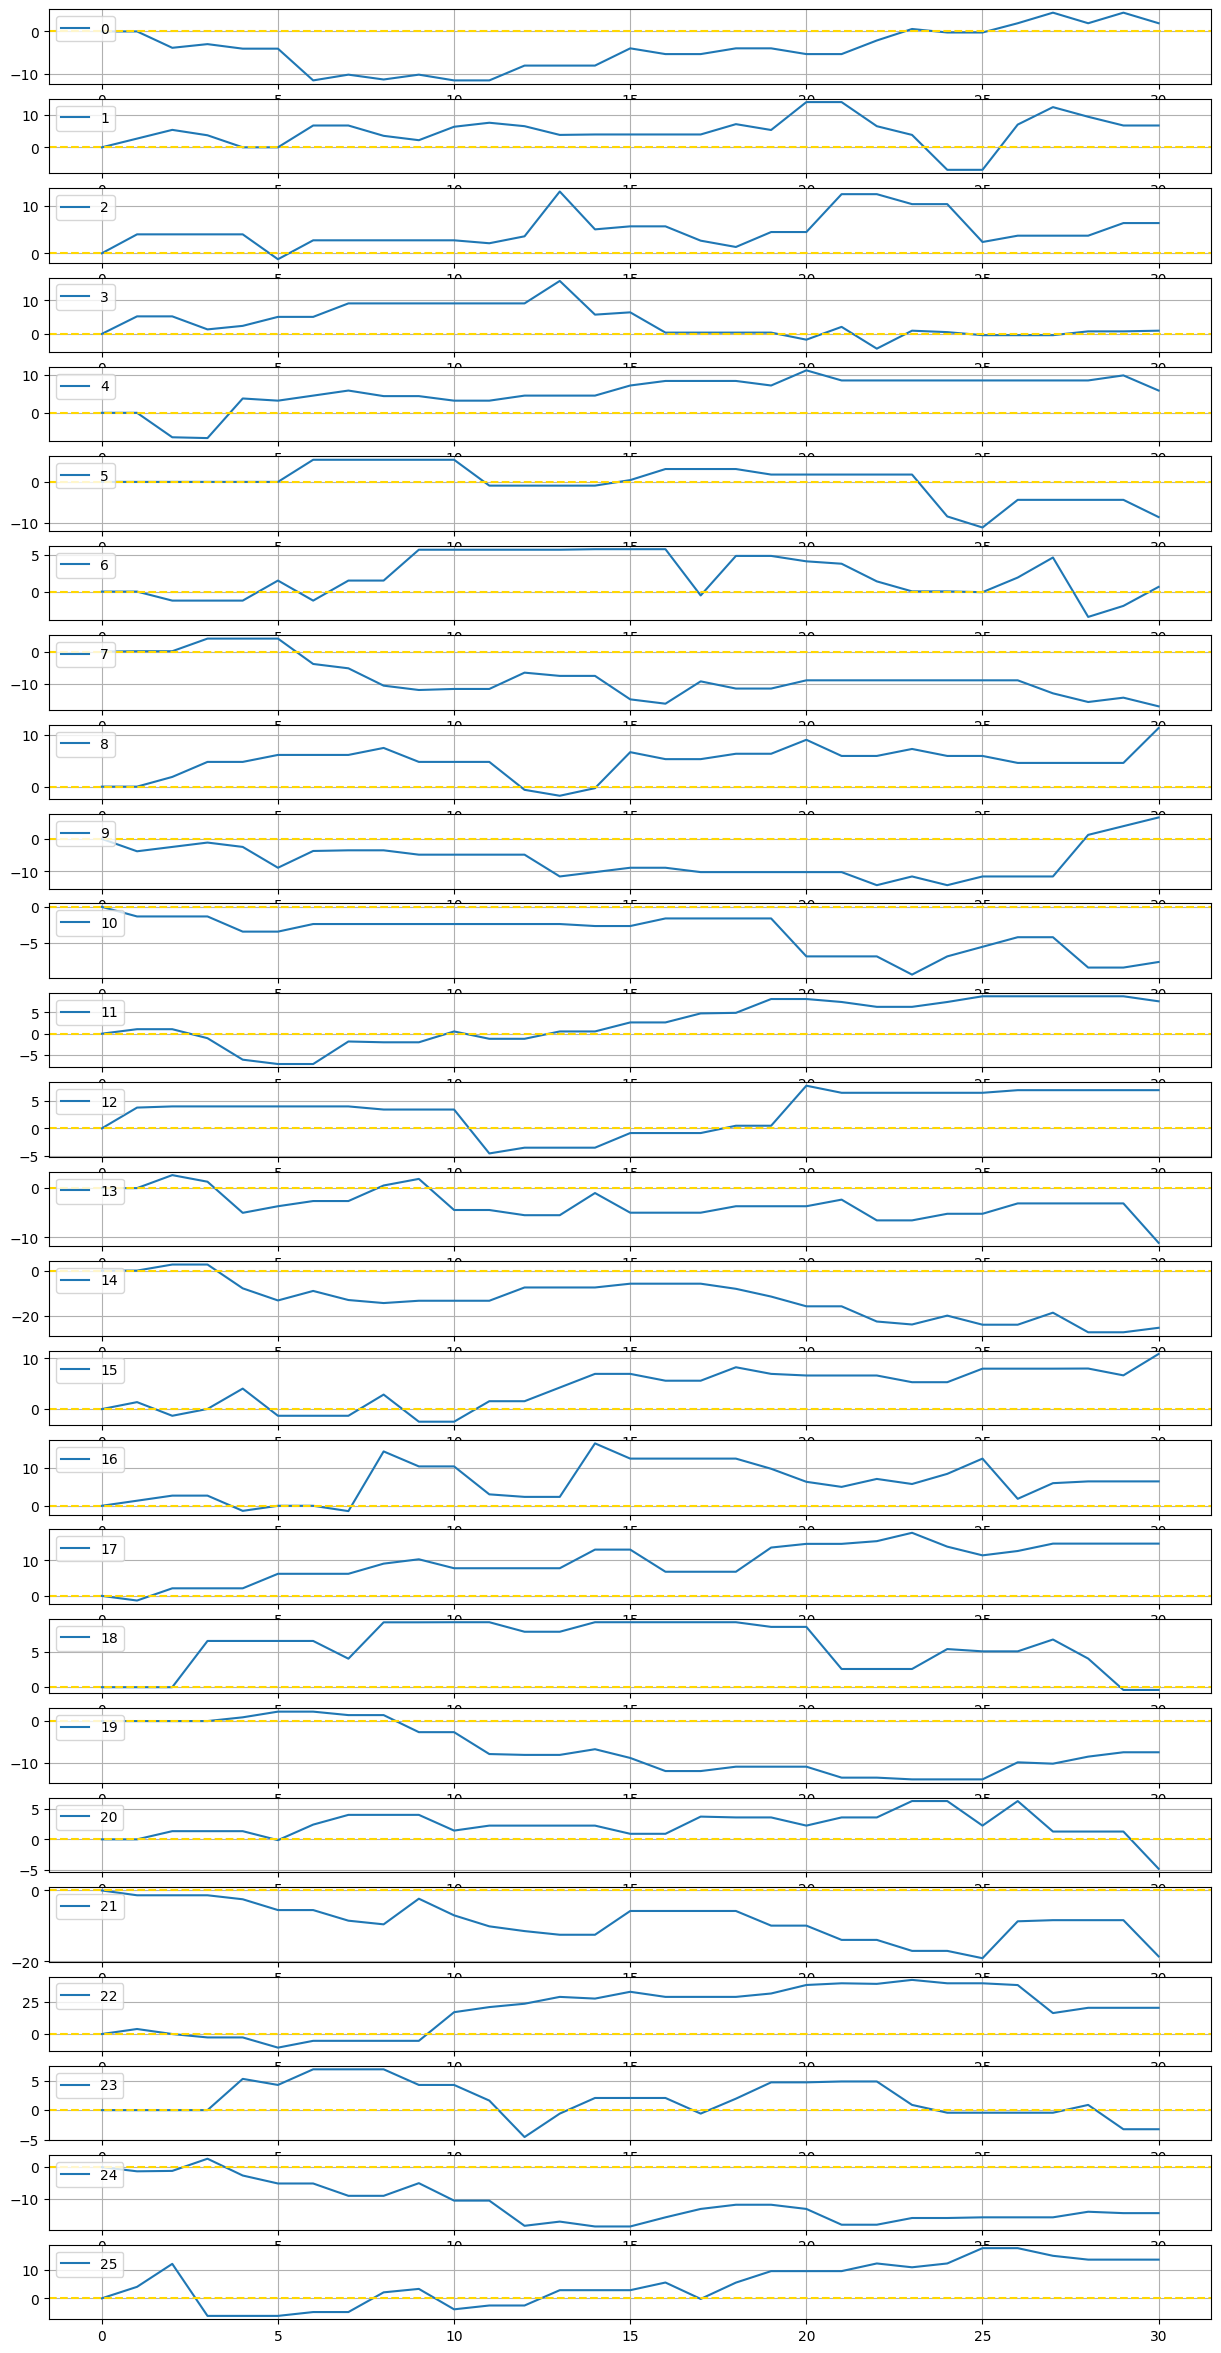

In [138]:
samples = ret.columns.tolist()
fig, ax = plt.subplots(nrows=len(samples), figsize=(15, 30))

for i, sample in enumerate(samples):
    ax[i].plot(ret[sample], label=sample)
    ax[i].legend(loc="upper left")
    ax[i].axhline(y=0, color="gold", linestyle="--")
    ax[i].grid()

plt.show()

In [135]:
ret

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1,-0.000000,2.673216e+00,4.011634,5.245392,-0.000000,-0.000000,-0.000000,0.121797,-0.000000,-3.812365,...,1.347439,-1.305200,-0.000000,-0.000000,-0.000000,-1.352960,3.942728,-0.000000,-1.333956,4.013376
2,-3.829347,5.346431e+00,4.011634,5.245392,-6.487066,-0.000000,-1.217951,0.121797,1.873349,-2.474867,...,2.695553,2.128651,-0.000000,-0.000000,1.356213,-1.352960,-0.000000,-0.000000,-1.201201,12.038791
3,-2.969766,3.688853e+00,4.011634,1.345083,-6.703123,-0.000000,-1.217951,4.046938,4.771536,-1.136700,...,2.695553,2.128651,6.578812,-0.000000,1.356213,-1.352960,-2.662360,-0.000000,2.668579,-6.139386
4,-4.031040,1.110223e-12,4.011634,2.401808,3.801720,-0.000000,-1.217951,4.046938,4.771536,-2.474867,...,-1.347439,2.128651,6.578812,0.896595,1.356213,-2.477012,-2.662360,5.318708,-2.668579,-6.139386
5,-4.031040,1.110223e-12,-1.262949,5.092646,3.223076,-0.000000,1.488141,4.046938,6.117669,-8.866842,...,-0.000000,6.206841,6.578812,2.253423,-0.135784,-5.519130,-10.655168,4.285043,-5.203602,-6.139386
6,-11.450192,6.682705e+00,2.748685,5.092646,4.563111,5.378782,-1.217951,-3.843760,6.117669,-3.716310,...,-0.000000,6.206841,6.578812,2.253423,2.441536,-5.519130,-5.327251,6.944397,-5.203602,-4.800435
7,-10.106736,6.682705e+00,2.748685,9.128567,5.903816,5.378782,1.488141,-5.193908,6.117669,-3.515512,...,-1.414825,6.206841,4.056023,1.425049,4.056717,-8.507136,-5.327251,6.944397,-9.126351,-4.800435
8,-11.235330,3.519611e+00,2.748685,9.128567,4.428947,5.378782,1.488141,-10.587758,7.466363,-3.515512,...,14.423157,9.060310,9.231532,1.425049,4.056717,-9.539028,-5.327251,6.944397,-9.126351,2.086805
9,-10.106736,2.183338e+00,2.748685,9.128567,4.428947,5.378782,5.654903,-11.936962,4.771536,-4.853679,...,10.446877,10.284079,9.231532,-2.644080,4.056717,-2.317353,-5.327251,4.285043,-5.100451,3.291058


In [90]:
pd.concat([pd.Series(a.values, name=(a.index[0], i)) for i, (b, a) in enumerate(trigger_before_after_dicts["CL=F"])], axis=1).iloc[-1].sort_values()

2024-03-01 15:07:00+00:00  25   -0.011711
2024-02-02 09:00:00+00:00  13   -0.004475
2024-02-12 15:58:00+00:00  18   -0.004180
2024-02-14 15:50:00+00:00  20   -0.003745
2024-02-16 15:35:00+00:00  23   -0.002310
2024-01-29 13:30:00+00:00  10   -0.002066
2024-01-29 15:44:00+00:00  0    -0.000778
2024-02-12 10:24:00+00:00  17   -0.000526
2024-02-05 13:50:00+00:00  3    -0.000415
2024-02-02 14:42:00+00:00  15   -0.000138
2024-02-16 14:50:00+00:00  22    0.000384
2024-02-29 15:01:00+00:00  24    0.000637
2024-01-30 12:27:00+00:00  11    0.000917
2024-02-05 15:02:00+00:00  16    0.001256
2024-02-16 09:00:00+00:00  21    0.001287
2024-02-07 15:44:00+00:00  5     0.001901
2024-02-29 15:55:00+00:00  9     0.001907
2024-01-31 09:14:00+00:00  12    0.003109
2024-02-15 14:53:00+00:00  7     0.003109
2024-02-15 15:28:00+00:00  8     0.003484
2024-02-09 14:24:00+00:00  6     0.003640
2024-02-06 14:40:00+00:00  4     0.004089
2024-01-30 15:49:00+00:00  2     0.005292
2024-01-30 14:06:00+00:00  1     0

In [91]:
trade_before_after_dicts["ISFLSE"][3]

(2024-02-05 13:21:00+00:00    0.001209
 2024-02-05 13:22:00+00:00    0.000960
 2024-02-05 13:23:00+00:00    0.000806
 2024-02-05 13:24:00+00:00    0.000806
 2024-02-05 13:25:00+00:00    0.000537
 2024-02-05 13:26:00+00:00    0.000537
 2024-02-05 13:27:00+00:00    0.000537
 2024-02-05 13:28:00+00:00    0.000537
 2024-02-05 13:29:00+00:00    0.000537
 2024-02-05 13:30:00+00:00    0.000537
 2024-02-05 13:31:00+00:00    0.000403
 2024-02-05 13:32:00+00:00    0.000403
 2024-02-05 13:33:00+00:00    0.000269
 2024-02-05 13:34:00+00:00    0.000269
 2024-02-05 13:35:00+00:00    0.000269
 2024-02-05 13:36:00+00:00    0.000269
 2024-02-05 13:37:00+00:00    0.000134
 2024-02-05 13:38:00+00:00   -0.000121
 2024-02-05 13:39:00+00:00    0.000390
 2024-02-05 13:40:00+00:00    0.000390
 2024-02-05 13:41:00+00:00    0.000134
 2024-02-05 13:42:00+00:00    0.000247
 2024-02-05 13:43:00+00:00   -0.000134
 2024-02-05 13:44:00+00:00   -0.000134
 2024-02-05 13:45:00+00:00   -0.000134
 2024-02-05 13:46:00+00:0